# Preparations

In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `/home/torkel.loman/mount/TeamJL/Torkel/Writings/2022, Catalyst/Catalyst-Fast-Biochemical-Modeling-with-Julia/Benchmarks/Catalyst`


## Fetch packages

In [2]:
using DiffEqBase, DifferentialEquations, OrdinaryDiffEq
using Catalyst, ModelingToolkit, ReactionNetworkImporters
using LSODA, Sundials
using DiffEqDevTools, ODEInterface, ODEInterfaceDiffEq
using TimerOutputs, BenchmarkTools
using LinearAlgebra
using Plots

┌ Info: Precompiling DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e]
└ @ Base loading.jl:1423
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1423
┌ Info: Precompiling Catalyst [479239e8-5488-4da2-87a7-35f2df7eef83]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this modu

### Declare algorithms

In [3]:
algs_multistate = [Dict(:alg=>lsoda()), Dict(:alg=>CVODE_BDF()), Dict(:alg=>TRBDF2()), Dict(:alg=>QNDF()), Dict(:alg=>FBDF()), Dict(:alg=>KenCarp4()), Dict(:alg=>Rosenbrock23()),Dict(:alg=>VCABM()), Dict(:alg=>Vern6())];
algs_multisite2 = [Dict(:alg=>lsoda()), Dict(:alg=>CVODE_BDF(linear_solver=:GMRES)), Dict(:alg=>TRBDF2(linsolve=KrylovJL_GMRES())), Dict(:alg=>QNDF(linsolve=KrylovJL_GMRES())), Dict(:alg=>FBDF(linsolve=KrylovJL_GMRES())), Dict(:alg=>KenCarp4(linsolve=KrylovJL_GMRES())), Dict(:alg=>Rosenbrock23(linsolve=KrylovJL_GMRES())),Dict(:alg=>VCABM()), Dict(:alg=>Vern6())];
algs_egfr_net = [Dict(:alg=>lsoda()), Dict(:alg=>CVODE_BDF(linear_solver=:GMRES)), Dict(:alg=>TRBDF2(linsolve=KrylovJL_GMRES())), Dict(:alg=>QNDF(linsolve=KrylovJL_GMRES())), Dict(:alg=>FBDF(linsolve=KrylovJL_GMRES())), Dict(:alg=>KenCarp4(linsolve=KrylovJL_GMRES())), Dict(:alg=>Rosenbrock23(linsolve=KrylovJL_GMRES()))];
algs_BCR = [Dict(:alg=>CVODE_BDF(linear_solver=:GMRES)), Dict(:alg=>TRBDF2(linsolve=KrylovJL_GMRES())), Dict(:alg=>QNDF(linsolve=KrylovJL_GMRES(),autodiff=false)), Dict(:alg=>FBDF(linsolve=KrylovJL_GMRES(),autodiff=false)), Dict(:alg=>KenCarp4(linsolve=KrylovJL_GMRES(),autodiff=false)), Dict(:alg=>Rosenbrock23(linsolve=KrylovJL_GMRES(),autodiff=false))];
algs_fceri_gamma2 = [Dict(:alg=>CVODE_BDF(linear_solver=:GMRES)), Dict(:alg=>TRBDF2(linsolve=KrylovJL_GMRES())), Dict(:alg=>QNDF(linsolve=KrylovJL_GMRES(),autodiff=false)), Dict(:alg=>FBDF(linsolve=KrylovJL_GMRES(),autodiff=false)), Dict(:alg=>KenCarp4(linsolve=KrylovJL_GMRES(),autodiff=false)), Dict(:alg=>Rosenbrock23(linsolve=KrylovJL_GMRES(),autodiff=false))];
methods1 = [("lsoda",:lightskyblue,:star4),("CVODE_BDF",:royalblue,:circle), ("TRBDF2",:lightslateblue,:diamond),("KenCarp4",:turquoise2,:rect),("QNDF",:navyblue,:dtriangle),("FBDF",:darkmagenta,:star5),("Rosenbrock23",:purple4,:heptagon),("VCABM",:deepskyblue4,:octagon),("Vern6",:darkorchid1,:star8)];
methods2 = [("lsoda",:lightskyblue,:star4),("CVODE_BDF",:royalblue,:circle), ("TRBDF2",:lightslateblue,:diamond),("KenCarp4",:turquoise2,:rect),("QNDF",:navyblue,:dtriangle),("FBDF",:darkmagenta,:star5),("Rosenbrock23",:purple4,:heptagon)];
methods3 = [("CVODE_BDF",:royalblue,:circle), ("TRBDF2",:lightslateblue,:diamond),("KenCarp4",:turquoise2,:rect),("QNDF",:navyblue,:dtriangle),("FBDF",:darkmagenta,:star5),("Rosenbrock23",:purple4,:heptagon)];

### Declare functions

In [4]:
function make_wp_digram(model, abstols, reltols; tf=100.0, numruns=100, algs=algs, jac=false, sparse=false)
    prnbng = loadrxnetwork(BNGNetwork(), "../Data/$(model).net");
    oprob = ODEProblem(convert(ODESystem, prnbng.rn), Float64[], (0.,tf), Float64[];jac=jac,sparse=sparse);
    
    u  = ModelingToolkit.varmap_to_vars(nothing, species(prnbng.rn); defaults=ModelingToolkit.defaults(prnbng.rn))
    du = copy(u)
    p  = ModelingToolkit.varmap_to_vars(nothing, parameters(prnbng.rn); defaults=ModelingToolkit.defaults(prnbng.rn))
    oprob.f(du,u,p,0.)
    oprob.f(du,u,p,0.)
    
    test_alg = (sparse ? CVODE_BDF(linear_solver=:KLU) : CVODE_BDF())
    test_sol= TestSolution(solve(oprob, test_alg, abstol=1/10^15, reltol=1/10^15));
    return WorkPrecisionSet(oprob,abstols,reltols,algs;error_estimate=:l2,saveat=tf/10000.,appxsol=test_sol,maxiters=Int(1e5),numruns=numruns)
end;

In [5]:
function plot_wp(wpd, methods; legendfontsize=7, legend=:topright, lw=20, la=0.8, markersize=20 ,markerstrokealpha=1.0, markerstrokewidth=1.5, gridalpha=0.3, gridlinewidth=2.5, kwargs...)
    (length(wpd.wps) != length(methods)) && error("Wpd and Methods should have equal length.")
    plot()
    for i in 1:length(wpd.wps)
        wp = wpd.wps[i]; method = methods[i]; 
        plot!(wp.errors,wp.times .* 1000,label="",color=method[2],makrershape=method[3],lw=lw,la=la,markersize=markersize,markerstrokealpha=markerstrokealpha,markerstrokewidth=markerstrokewidth,gridalpha=gridalpha)
        plot!(wp.errors,wp.times .* 1000,seriestype=:scatter,label=method[1],color=method[2],markershape=method[3],lw=lw,la=la,markersize=markersize,markerstrokealpha=markerstrokealpha,markerstrokewidth=markerstrokewidth,gridalpha=gridalpha,gridlinewidth=gridlinewidth)
    end
    plot!(;legendfontsize=legendfontsize,legend=legend,xguide="Error",yguide="Time (ms)",framestyle=:box,size=(1100,1000),xaxis=:log10,yaxis=:log10, kwargs...)
end;

# Run Benchmarks

In [6]:
@time wp_multistate = make_wp_digram("multistate", 0.1 .^(6:10), 0.1 .^(6:10); algs=algs_multistate, tf=20.0, numruns=1000)
wp_multistate_plot = plot!(plot_wp(wp_multistate,methods1;title="Multistate"),xlimit=(1e-10,1e0),ylimit=(1e0,1e2),xticks=[1e-10,1e-8,1e-6,1e-4,1e-2,1e0]);

Parsing parameters...done
Creating parameters...done
Parsing species...done
Creating species...done
Creating species and parameters for evaluating expressions...done
Parsing and adding reactions...done
Parsing groups...done
412.735380 seconds (1.17 G allocations: 117.354 GiB, 5.70% gc time, 34.30% compilation time)


In [75]:
#@time wp_multisite2 = make_wp_digram("multisite2",0.1 .^(6:10),0.1 .^(6:10); algs=algs_multisite2, tf=2.0, numruns=500)
wp_multisite2_plot = plot_wp(wp_multisite2,methods1;title="Multisite2",xlimit=(1e-10,1e0),ylimit=(1e0,1e3),xticks=[1e-10,1e-8,1e-6,1e-4,1e-2,1e0]);

In [77]:
#@time wp_egfr_net = make_wp_digram("egfr_net",0.1 .^(6:10),0.1 .^(6:10);algs=algs_egfr_net, tf=10.0, numruns=500)
wp_egfr_net_plot = plot_wp(wp_egfr_net,methods2;title="Egfr_net",xlimit=(1e-8,1e0),ylimit=(1e1,1e4));

In [79]:
#@time wp_BCR = make_wp_digram("BCR",0.1 .^(5:8),0.1 .^(5:8); numruns=50, tf=10.0, algs=algs_BCR)
wp_BCR_plot = plot_wp(wp_BCR,methods3;title="BCR",xlimit=(1e-7,1e-2),ylimit=(1e2,1e4));

In [82]:
#@time wp_fceri_gamma2_2 = make_wp_digram("fceri_gamma2",0.1 .^(5:8),0.1 .^(5:8); numruns=10, tf=200.0, algs=algs_fceri_gamma2)
wp_fceri_gamma2_plot = plot_wp(wp_fceri_gamma2_2,methods3;title="Fceri_gamma2",xlimit=(1e-7,1e-1),ylimit=(1e3,1e6),xticks=[1e-7,1e-5,1e-3,1e-1]);

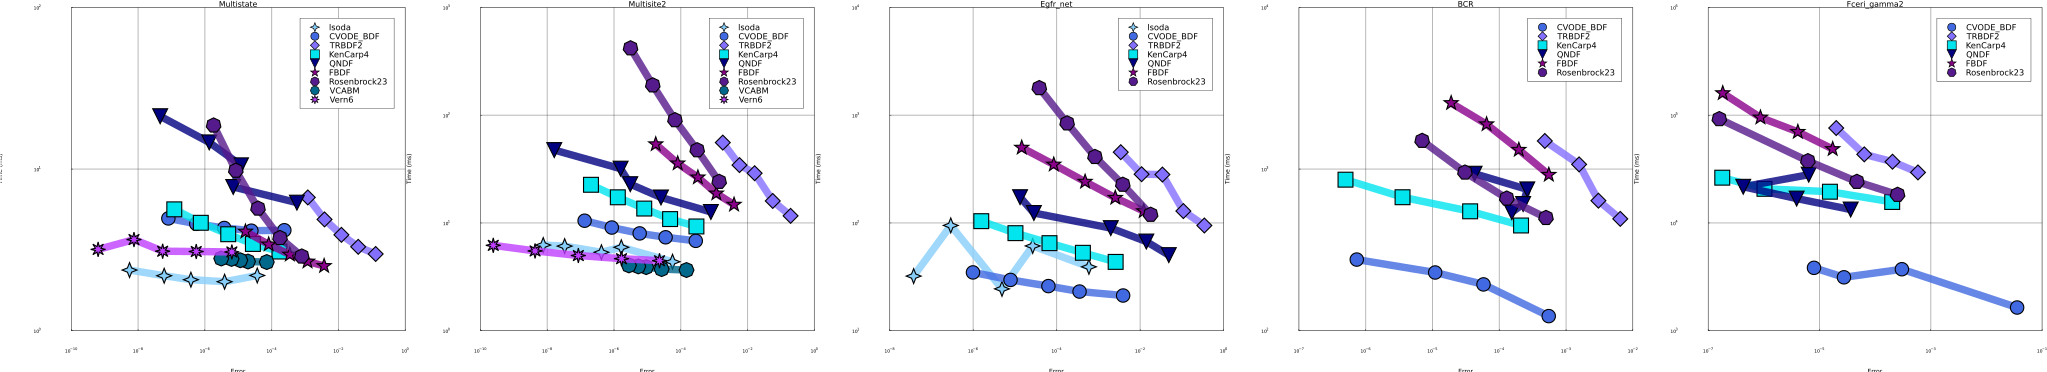

In [83]:
combined_wp_plot = plot(wp_multistate_plot, wp_multisite2_plot, wp_egfr_net_plot, wp_BCR_plot, wp_fceri_gamma2_plot, 
    layout=(1,5),size=(5500,1000),left_margin=25Plots.mm,bottom_margin=20Plots.mm,legendfontsize=15)

In [85]:
savefig(plot!(combined_wp_plot;legend=:none,title="",xguide="",yguide=""),"../../Figures/Work_Prection_Diagrams/work_precision_diagram_draft.png")
savefig(plot!(combined_wp_plot;legend=:none,title="",xguide="",yguide=""),"../../Figures/Work_Prection_Diagrams/work_precision_diagram_draft.svg")